In [3]:
import numpy as np 
import torch 
import torch.nn as nn
import gym 
import matplotlib.pyplot as plt
from torch.autograd import Variable

from Visualisation import render_averages_plot, render_plot_with_hist

# define the model 

class DQN():

    def __init__(self, state_dim, action_dim, lr):
        super(DQN, self).__init__()
        SIZE = 64

        self.nn = nn.Sequential(
                torch.nn.Linear(state_dim, SIZE),
                nn.LeakyReLU(),
                nn.Linear(SIZE, SIZE * 2),
                nn.LeakyReLU(),
                nn.Linear(SIZE * 2, action_dim)
        )

        self.loss = nn.MSELoss()
        self.optimiser = torch.optim.Adam(self.nn.parameters(), lr)


    def update(self, state, y):
        y_pred = self.nn(torch.Tensor(state))
        loss = self.loss(y_pred, Variable(torch.Tensor(y)))
        # print(loss.item())
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        return y_pred, loss.item()
        


    def predict(self, state):
        with torch.no_grad():
            return self.nn(torch.Tensor(state))

In [4]:

def train(env, model, episodes, gamma, epsilon, decay):


    final_reward = []
    goal_achieved = 0   
    episode_num = 0
    average_loss_per_ep = []
    act_q_0 = []
    act_q_1 = []
    pred_q_0 = []
    pred_q_1 = []
    failures = []
    cart_position = []
    pole_angle = []
    q_list = []
    
    
    

    for _ in range(episodes):
        loss_ep = []
        episode_num +=1
        state = env.reset()
        done = False
        total = 0
        
        
        
        while not done:
            q_values = model.predict(state)
            
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = torch.argmax(q_values).item()

            next_state, reward, done, _ = env.step(action)
            
            # state[0] is cart position
            # state[2] is pole angle 
            cart_position.append(state[0])
            pole_angle.append(state[2])
            
            #env.render()
            total += reward

            if done:
                q_values[action] = reward
                y_pred, loss = model.update(state, q_values)
                loss_ep.append(loss)
                act_q_0.append(q_values[0].item())
                act_q_1.append(q_values[1].item())
                q_list += [q_values]
                #q_s = torch.stack((q_s, q_values), dim=0)
                
                pred_q_0.append(y_pred[0].item())
                pred_q_1.append(y_pred[1].item())
                
                break 

            q_values_next = model.predict(next_state)
            # print(q_values_next)
            q_values[action] = reward + gamma * torch.max(q_values_next).item()
            q_list += [q_values]
            #q_s = torch.stack((q_s, q_values), dim=0)
            # print(q_values)
            act_q, loss = model.update(state, q_values)
            
            
            # print("Next", q_values_next)
            
            
            act_q_0.append(act_q[0].item())
            act_q_1.append(act_q[1].item())
            
            pred_q_0.append(q_values[0].item())
            pred_q_1.append(q_values[1].item())
            
            loss_ep.append(loss)
            state = next_state
    
        epsilon = max(epsilon * decay, 0.01)
        final_reward.append(total)
        avg_loss = np.mean(loss_ep)
        average_loss_per_ep.append(avg_loss)
        if total >= 200:
            goal_achieved += 1
        # print("Episode number:", episode_num, "Reward:", total, "Epsilon:", epsilon)
        # print("Q values", q_values)
        # print("State", state)
        
 
    
    # return final_reward, goal_achieved
    # return final_reward, goal_achieved, average_loss_per_ep
    q_s = torch.stack(tuple([q for q in q_list]))
    # max_qs = [max(q).item() for q in q_s]
    
    
    return q_s, cart_position, pole_angle
    # return final_reward, goal_achieved, average_loss_per_ep, act_q_0, pred_q_0, act_q_1, pred_q_1




In [5]:
def average(runs, env, episodes):
    all_rewards = []
    successes = []

    for _ in range(runs):
        model = DQN(obs_dim, action_dim, lr)
        rewards, goals = train(env, model, episodes, gamma, epsilon, decay)
        all_rewards.append(rewards)
        successes.append(goals)

    
    rewards_array = np.array([np.array(i) for i in all_rewards])
    return rewards_array, successes


In [6]:

# parameters
episodes = 10
lr = 0.001

gamma = 0.9
epsilon = 0.3
decay = 0.99
UPDATE = 10




In [7]:
env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
model = DQN(obs_dim, action_dim, lr)

In [8]:
rew, goals = average(10, env, 200)

KeyboardInterrupt: 

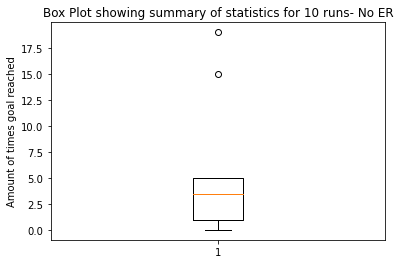

In [14]:
plt.boxplot(goals, meanline=True)
plt.title("Box Plot showing summary of statistics for 10 runs- No ER")
plt.ylabel("Amount of times goal reached")
plt.show()

In [34]:
print(goals)

[1, 0, 1, 2, 7, 0, 1, 3, 0, 0]


In [65]:
rewards, goals, mean_loss, actual_0, predicted_0, actual_1, predicted_1 = train(env, model, episodes, gamma, epsilon, decay)
# rewards, goals, mean_loss, failures = 

Episode number: 1 Reward: 8.0 Epsilon: 0.297
Episode number: 2 Reward: 9.0 Epsilon: 0.29402999999999996
Episode number: 3 Reward: 9.0 Epsilon: 0.29108969999999995
Episode number: 4 Reward: 11.0 Epsilon: 0.28817880299999993
Episode number: 5 Reward: 11.0 Epsilon: 0.28529701496999993
Episode number: 6 Reward: 12.0 Epsilon: 0.28244404482029994
Episode number: 7 Reward: 11.0 Epsilon: 0.27961960437209693
Episode number: 8 Reward: 9.0 Epsilon: 0.276823408328376
Episode number: 9 Reward: 10.0 Epsilon: 0.27405517424509224
Episode number: 10 Reward: 10.0 Epsilon: 0.2713146225026413
Episode number: 11 Reward: 11.0 Epsilon: 0.2686014762776149
Episode number: 12 Reward: 10.0 Epsilon: 0.26591546151483875
Episode number: 13 Reward: 12.0 Epsilon: 0.2632563068996904
Episode number: 14 Reward: 10.0 Epsilon: 0.2606237438306935
Episode number: 15 Reward: 10.0 Epsilon: 0.2580175063923865
Episode number: 16 Reward: 10.0 Epsilon: 0.25543733132846264
Episode number: 17 Reward: 13.0 Epsilon: 0.252882958015178

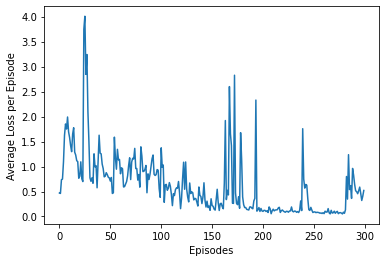

In [66]:
plt.plot(range(episodes), mean_loss)
# plt.vlines(failures, 0, 10)
plt.xlabel("Episodes")
plt.ylabel("Average Loss per Episode")
plt.show()

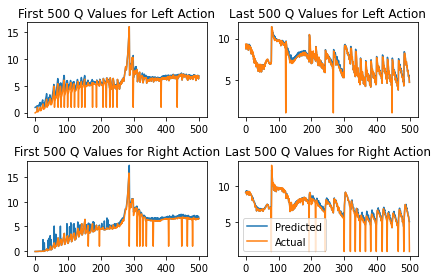

In [78]:
f, ax = plt.subplots(nrows=2,ncols=2)
ax[0,0].plot(predicted_0[:500], label="Predicted")
ax[0,0].plot(actual_0[:500], label="Actual")
ax[0,0].title.set_text("First 500 Q Values for Left Action")

ax[0,1].plot(predicted_0[-500:], label="Predicted")
ax[0,1].plot(actual_0[-500:], label="Actual")
ax[0,1].title.set_text("Last 500 Q Values for Left Action")

ax[1,0].plot(predicted_1[:500], label="Predicted")
ax[1,0].plot(actual_1[:500], label="Actual")
ax[1,0].title.set_text("First 500 Q Values for Right Action")


ax[1,1].plot(predicted_1[-500:], label="Predicted")
ax[1,1].plot(actual_1[-500:], label="Actual")
ax[1,1].title.set_text("Last 500 Q Values for Right Action")

plt.tight_layout()
plt.legend()
plt.show()

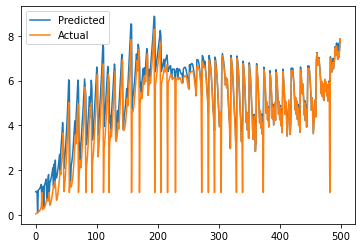

In [28]:
plt.plot(predicted_1[:500],label="Predicted")
plt.plot(actual_1[:500],label="Actual")
plt.legend()
plt.show()


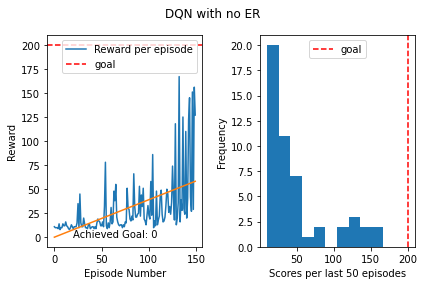

In [13]:
render_plot_with_hist(range(episodes), rewards, goals, "DQN with no ER", True, "SRHist")

In [ ]:
rewards, goals = average(3, env, episodes)

In [22]:
q, pos, angle = train(env, model, 100, gamma, epsilon, decay)

In [23]:
print(type(q), len(pos), len(angle))

print(q.T[0])


<class 'torch.Tensor'> 9538 9538
tensor([8.8595, 7.2389, 7.3942,  ..., 5.6776, 6.1690, 1.0000])


In [24]:
#8.5
#8.3
q_max = torch.max(q, axis=1)
print(q_max)

numpy_q = q_max[0].numpy()
print(numpy_q)

torch.return_types.max(
values=tensor([8.8595, 8.4745, 7.9122,  ..., 6.4599, 6.7796, 6.3543]),
indices=tensor([0, 1, 1,  ..., 1, 1, 1]))
[8.859462 8.474484 7.912179 ... 6.459882 6.779583 6.354253]


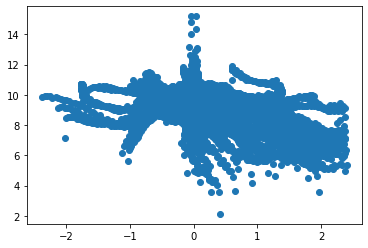

In [25]:
plt.scatter(pos, q_max[0])

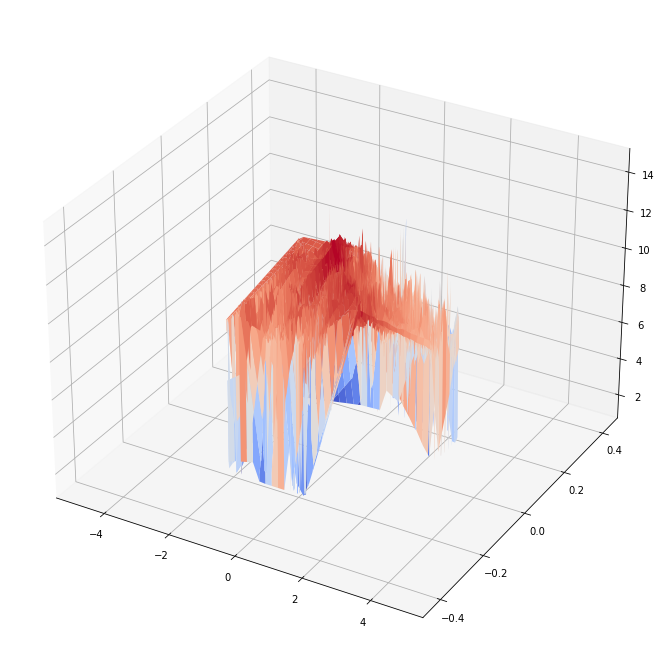

In [27]:
from matplotlib import cm
from scipy.interpolate import griddata


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')



x_min, x_max = env.observation_space.low[0], env.observation_space.high[0]
y_min, y_max = env.observation_space.low[2], env.observation_space.high[2]

x_space = np.linspace(x_min, x_max, len(pos))
y_space = np.linspace(y_min, y_max, len(angle))
X, Y = np.meshgrid(x_space, y_space)

Z = griddata((pos, angle), q.T[0], (X, Y), method='linear')
Z_p = griddata((pos, angle), q.T[1], (X, Y), method='linear')
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
ax.plot_surface(X, Y, Z_p, cmap=cm.coolwarm)

plt.show()